# **Import libraries**

**Install some libaries**

In [ ]:
! pip install arabic-reshaper
! pip install python-bidi

In [ ]:
# Install Hazm
! pip install hazm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 16.9 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=ad07d1ae6e977a516203c724c3ab7ba6faa802c274618160f53b5784b59de3db
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [ ]:
! pip install huggingface

<font color='skyblie' size='4px'>**Kaggle**</font> **should be downloaded**

In [ ]:
# ! pip install kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import warnings
warnings.filterwarnings('ignore')
import torch
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from gensim.models import FastText, Word2Vec
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from hazm import *
import huggingface
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from huggingface_hub import hf_hub_download
import fasttext
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel, AdamW

**Kaggle.json must be donwloaded**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"armintorajmehr","key":"2716589d699ff031ac2d20a143588b10"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d radeai/digikala-comments-and-products

Dataset URL: https://www.kaggle.com/datasets/radeai/digikala-comments-and-products
License(s): DbCL-1.0
 94% 303M/324M [00:02<00:00, 169MB/s]
100% 324M/324M [00:02<00:00, 147MB/s]


In [ ]:
! unzip digikala-comments-and-products.zip

Archive:  digikala-comments-and-products.zip
  inflating: digikala-comments.csv   
  inflating: digikala-products.csv   


In [ ]:
# Read csv data
data = pd.read_csv('digikala-comments.csv')
# data2 = pd.read_csv('digikala-products.csv')


In [ ]:
# Creat a DataFrame
comment_df = pd.DataFrame(data)
# product_df = pd.DataFrame(data2)

# **Exploratory Data Analysis**

**Step 1**:
- <font color='blue'>**Check the type of each column.**</font>
- <font color='blue'>**Explore which type's column or columns need to be converted.**</font>


In [ ]:
# Check info
comment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6156289 entries, 0 to 6156288
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     int64  
 1   title                  object 
 2   body                   object 
 3   created_at             object 
 4   rate                   float64
 5   recommendation_status  object 
 6   is_buyer               bool   
 7   product_id             int64  
 8   advantages             object 
 9   disadvantages          object 
 10  likes                  int64  
 11  dislikes               int64  
 12  seller_title           object 
 13  seller_code            object 
 14  true_to_size_rate      object 
dtypes: bool(1), float64(1), int64(4), object(9)
memory usage: 663.4+ MB


Body column needs to converted to <font color='blue'>**string.**</font>

**Why?**
- **To get the length of texts I want later**




In [ ]:
# Change type of body to str
comment_df['body'] = comment_df['body'].astype(str)

Out of curiosity, We want to check in which year we had the highest sales.

First we need to separate the month and year from the **created_at** column.

In [ ]:
comment_df['month'] = comment_df['created_at'].str.split(' ').str[1]
comment_df['year'] = comment_df['created_at'].str.split(' ').str[2]

In [ ]:
comment_df.head()

,id,body,rate,recommendation_status,is_buyer,product_id,likes,dislikes,month,year
0,53672599,به درد نمیخوره,1.0,not_recommended,True,252058,0,0,شهریور,1402
1,9897229,می‌تونست به عنوان یه کالای فرهنگی بهتر بسته بن...,0.0,recommended,True,252058,1,0,تیر,1399
2,38074516,بسته بندیش خوب بود\r\n کاربرد و کیفیتشم خیلی خ...,0.0,recommended,True,3331597,0,0,مرداد,1401
3,18628562,به نظرم خوبه فقط یکم ظریفه. از رنگش خوشم اومد ...,0.0,recommended,True,3331329,0,0,اسفند,1399
4,53301258,معمولیه اگه واسه خونه رنگ کردن شخصی میخواین او...,3.0,recommended,True,3255700,0,0,شهریور,1402


Excellent!!🙂

We just analyze data on people who bought the product.

In [ ]:
# People who bought the product
total_sell_year = pd.DataFrame(comment_df[comment_df['is_buyer'] == True].groupby('year')['month'].count())
total_sell_year

<Axes: xlabel='year', ylabel='month'>

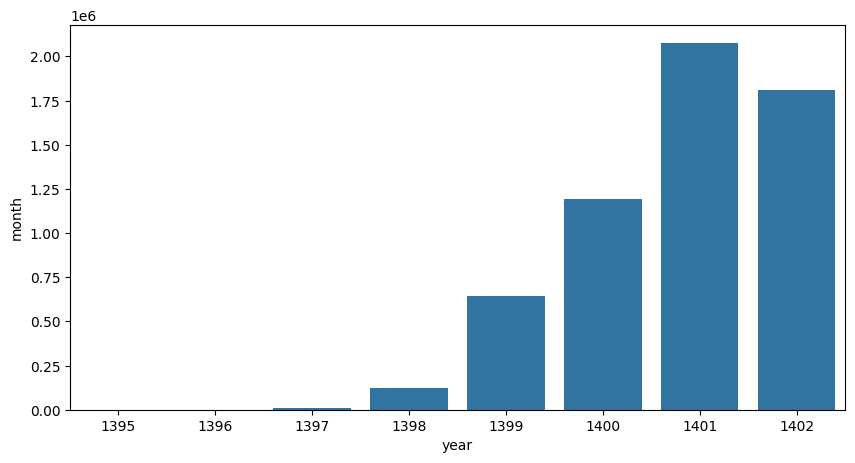

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=total_sell_year.index,y=total_sell_year['month'])

As can be seen, The largest number of products were sold in <font color='blue'>**1402**.</font>

Now we are going to check which month is sold product the most.

In [ ]:
# Group by year and month
# How many prodcuts were sold per month in 1402
total_sell_year_month = pd.DataFrame(comment_df[comment_df['is_buyer'] == True].groupby(['year','month'])['id'].count())

In [ ]:
total_sell_year_month.reset_index('year',inplace=True)

In [ ]:
# Filter data for 1402 year
filter_1402 = total_sell_year_month[total_sell_year_month['year'] == '1402']
filter_1402

,year,id
month,,
اردیبهشت,1402,222320
تیر,1402,293232
خرداد,1402,291197
شهریور,1402,305241
فروردین,1402,223834
مرداد,1402,261729
مهر,1402,209950


In [ ]:
month_name = filter_1402.index.to_list()
persian_labels = [get_display(reshape(label)) for label in month_name]

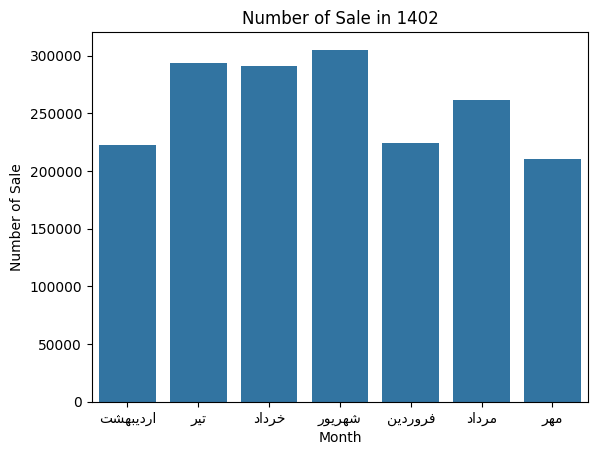

In [ ]:
sns.barplot(x=persian_labels,y=filter_1402['id'])
plt.title('Number of Sale in 1402')
plt.xlabel('Month')
plt.ylabel('Number of Sale')
plt.show()

The distribution of the graph is almost **uniform**, but as the data is only for the first six months of the year.

In [ ]:
comment_df['month'] = comment_df['created_at'].str.split(' ').str[1]
comment_df['year'] = comment_df['created_at'].str.split(' ').str[2]

In [ ]:
comment_df.head()

,id,body,rate,recommendation_status,is_buyer,product_id,likes,dislikes,month,year
0,53672599,به درد نمیخوره,1.0,not_recommended,True,252058,0,0,شهریور,1402
1,9897229,می‌تونست به عنوان یه کالای فرهنگی بهتر بسته بن...,0.0,recommended,True,252058,1,0,تیر,1399
2,38074516,بسته بندیش خوب بود\r\n کاربرد و کیفیتشم خیلی خ...,0.0,recommended,True,3331597,0,0,مرداد,1401
3,18628562,به نظرم خوبه فقط یکم ظریفه. از رنگش خوشم اومد ...,0.0,recommended,True,3331329,0,0,اسفند,1399
4,53301258,معمولیه اگه واسه خونه رنگ کردن شخصی میخواین او...,3.0,recommended,True,3255700,0,0,شهریور,1402


In [ ]:
total_sell_year = pd.DataFrame(comment_df[comment_df['is_buyer'] == True].groupby('year')['month'].count())
total_sell_year

<Axes: xlabel='year', ylabel='month'>

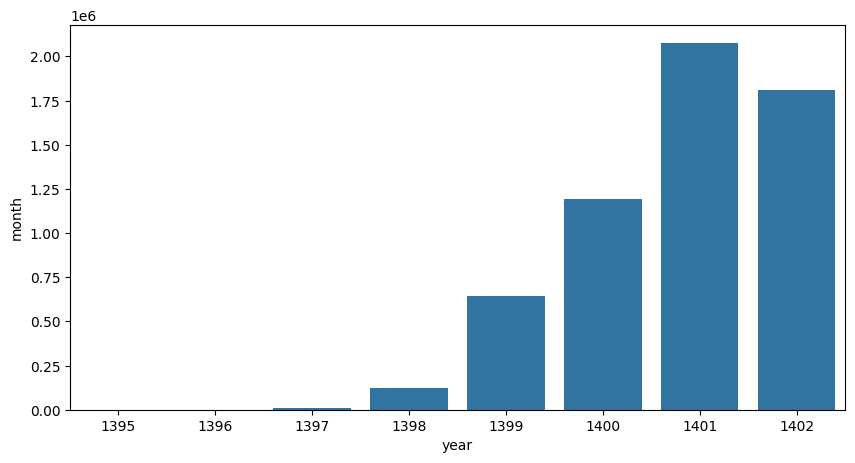

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=total_sell_year.index,y=total_sell_year['month'])

In [ ]:
total_sell_year_month = pd.DataFrame(comment_df[comment_df['is_buyer'] == True].groupby(['year','month'])['id'].count())

In [ ]:
total_sell_year_month.reset_index('year',inplace=True)

In [ ]:
filter_1402 = total_sell_year_month[total_sell_year_month['year'] == '1402']
filter_1402

,year,id
month,,
اردیبهشت,1402,222320
تیر,1402,293232
خرداد,1402,291197
شهریور,1402,305241
فروردین,1402,223834
مرداد,1402,261729
مهر,1402,209950


In [ ]:
! pip install arabic-reshaper
! pip install python-bidi

In [ ]:
from bidi.algorithm import get_display
from arabic_reshaper import reshape

In [ ]:
month_name = filter_1402.index.to_list()
persian_labels = [get_display(reshape(label)) for label in month_name]

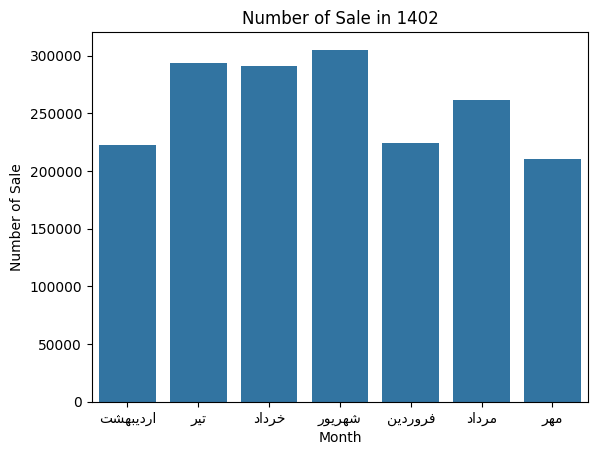

In [ ]:
sns.barplot(x=persian_labels,y=filter_1402['id'])
plt.title('Number of Sale in 1402')
plt.xlabel('Month')
plt.ylabel('Number of Sale')
plt.show()

**How many products were recommended?**

In [ ]:
# How many products are recommended?
recommended = comment_df['recommendation_status'].value_counts()
recommended

,count
recommendation_status,
recommended,4162417
no_idea,594078
not_recommended,504867


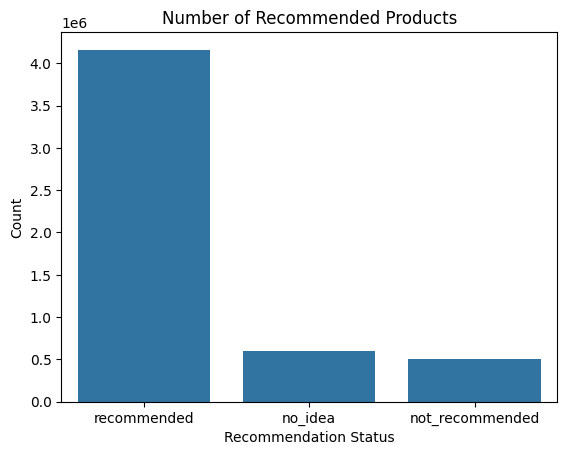

In [ ]:
sns.barplot(x=recommended.index,y=recommended.values)
plt.title('Number of Recommended Products')
plt.xlabel('Recommendation Status')
plt.ylabel('Count')
plt.show()

**Recommended** has a large gap with **no_idea** and **not_recommended**

**Step 2**:
- <font color='blue'>**Cheking null values**</font>
- <font color='blue'>**Cheking outliers**</font>
- <font color='blue'>**Checking noisy data**</font>
- <font color='blue'>**Analyzing important and unimportant features**</font>


Let's go to check how many missing values there are in the dataset.


In [ ]:
comment_df.isnull().sum()

,0
id,0
title,2865062
body,637
created_at,0
rate,0
recommendation_status,894426
is_buyer,0
product_id,0
advantages,5448084
disadvantages,5744017


As we can see many columns have **null values**

<font color='blue'>What can we do?</font>
- We can fill null values in some ways like median, mean, mode for numerical columns
- We can check on the internet to fill the null values if possible
- We can drop some columns that are not important for our analysis

and so on.



There are many usefull methods to fill null values <font color='red'>**but**</font> in our analysis it's better to drop unimportant columns.

<font color='blue'>**Let's do that:**</font>

Before remove some columns, Let's check how many percentages of null values ​​are there in the advantages and disadvantages columns:

In [ ]:
# For advantages column
null_values_adv = comment_df['advantages'].isnull().sum()
size_adv = comment_df.shape[0]
print(f'The percentage of null values for advantages column: {round((null_values_adv / size_adv) * 100,2)}%')

# For disadvantages column
null_values_dis = comment_df['disadvantages'].isnull().sum()
size_dis = comment_df.shape[0]
print(f'The percentage of null values for disadvantages column: {round((null_values_dis / size_dis) * 100,2)}%')

The percentage of null values for advantages column: 88.5%
The percentage of null values for disadvantages column: 93.3%


Ooops 😯

There are so many null values in these columns thus there should be dropped.

But before removing the columns for curiosity, let's check which stores had the highest number of rates:

In [ ]:
seller_most_rate = comment_df.groupby('seller_title')['rate'].count()[:10]
seller_most_rate.sort_values(ascending=False)

,rate
seller_title,
مهرگل,423
آذر کالا,316
دریم کالا,262
آرامد حدیث,228
فروشگاه بانو,171
آذیموس,133
کنکاش,61
آمیتیس,57
ارزان کده نازنین,27


Good.

In <font color='blue'>is_buyer</font> column there are 2 boolean:
- <font color='green'>**True**</font>, It means that person buy the product.
- <font color='red'>**False**</font>, It means that person doesn't buy the product.

Check how many of people weather buy product or not.

In [ ]:
# What percentage of people bought the product?
count_buyer = round((comment_df['is_buyer'].value_counts()[0] / comment_df.shape[0]) * 100,2)
count_not_buyer = round((comment_df['is_buyer'].value_counts()[1] / comment_df.shape[0]) * 100,2)
print(f'Percentage of people weather buy product: {count_buyer}%')
print(f'Percentage of people weather not buy product: {count_not_buyer}%')

Percentage of people weather buy product: 95.09%
Percentage of people weather not buy product: 4.91%


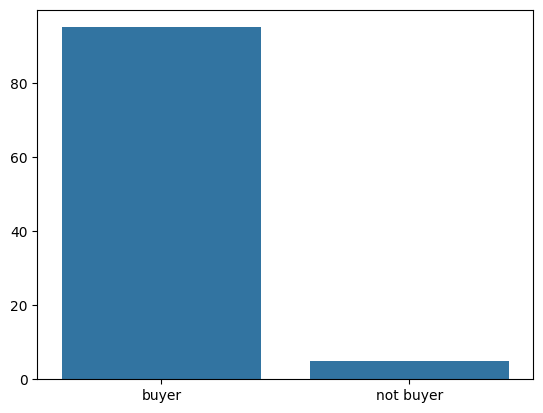

In [ ]:
# plot count_buyer and count_not_buyer
sns.barplot(x=['buyer','not buyer'], y=[count_buyer,count_not_buyer])
plt.show()

It's better to remove cases that didn't buy product

How about <font color='blue'>**recommendation_status**</font> column?

Let's go to analyze:

In [ ]:
# How many products are recommended?
recommended = comment_df['recommendation_status'].value_counts()

In [ ]:
# How many percentage of products were recommended by poeple?
rate_recommended = round((recommended['recommended'] / recommended.sum()) * 100,1)
rate_not_recommended = round((recommended['not_recommended'] / recommended.sum()) * 100,1)
rate_noidea = round((recommended['no_idea'] / recommended.sum()) * 100,1)

print(f'Rate of recommended products: {rate_recommended}%')
print(f'Rate of not recommended products: {rate_not_recommended}%')
print(f'Rate of no idea products: {rate_noidea}%')

Rate of recommended products: 79.1%
Rate of not recommended products: 9.6%
Rate of no idea products: 11.3%


Ummm 🤔

That's cool.

How about <font color='red'>**noisy**</font> and <font color='orange'>**outliers**</font> data points?

The <font color='blue'>**rate**</font> and <font color='blue'>**body**</font> columns are the **most important** columns in my analysis, but before working with these columns, it is better to check to see how many percentages or how much data noise or outliers there are.

In [ ]:
# How many unique data are there in rate column
comment_df['rate'].unique()

array([1.00e+00, 0.00e+00, 3.00e+00, 5.00e+00, 2.00e+00, 4.00e+00,
       4.25e+00, 4.50e+00, 3.75e+00, 3.25e+00, 2.75e+00, 5.00e-01,
       4.75e+00, 3.50e+00, 4.60e+00, 1.50e+00, 2.00e-01, 2.50e+00,
       4.40e+00, 1.80e+00, 2.65e+00, 2.25e+00, 3.40e+00, 4.80e+00,
       4.65e+00, 3.80e+00, 4.20e+00, 2.70e+00, 2.60e+00, 3.85e+00,
       3.60e+00, 1.70e+00, 4.30e+00, 2.15e+00, 4.85e+00, 1.90e+00,
       4.70e+00, 3.30e+00, 2.80e+00, 1.40e+00, 2.40e+00, 3.35e+00,
       4.35e+00, 3.70e+00, 2.90e+00, 1.20e+00, 1.25e+00, 4.45e+00,
       3.20e+00, 1.60e+00, 2.20e+00, 4.33e+00, 1.33e+00, 4.00e-01,
       8.00e-01, 4.67e+00, 1.50e-01, 1.75e+00, 4.10e+00, 2.50e-01,
       3.10e+00, 3.90e+00, 1.00e-01, 2.67e+00, 3.67e+00, 3.33e+00,
       2.33e+00, 1.67e+00, 7.50e-01, 1.30e+00, 4.90e+00, 2.30e+00,
       3.55e+00, 4.15e+00, 3.45e+00, 1.45e+00, 4.05e+00, 3.00e-01,
       4.55e+00, 3.65e+00, 2.10e+00, 1.85e+00, 3.05e+00, 8.50e-01,
       7.00e-01, 3.95e+00, 2.45e+00, 1.55e+00, 2.05e+00, 2.95e

In [ ]:
# describe rate column and stack
comment_df['rate'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
rate,6156289.0,3.648286,1.861854,0.0,3.0,4.0,5.0,2500.0


So, It seems there is a outlier. max is **2500** and it doesn't make sense because the range of rate is between 0 to 5.

Let's check it

In [ ]:
# check if there are cases with rate bigger than 5
comment_df[comment_df['rate'] > 5]

,id,title,body,created_at,rate,recommendation_status,is_buyer,product_id,advantages,disadvantages,likes,dislikes,seller_title,seller_code,true_to_size_rate
4369260,38631814,زیبا,کوچک و با کیفیت,9 شهریور 1401,2500.0,recommended,True,5095301,NaN,NaN,0,0,مستر راد,A4Z54,NaN


Excellent!

so it should be removed.


In [ ]:
# Remove outlier
outlier_index = comment_df[(comment_df['rate'] < 0) | (comment_df['rate'] > 5)].index
comment_df.drop(outlier_index,inplace=True)

In [ ]:
comment_df['rate'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
rate,6156288.0,3.64788,1.566601,0.0,3.0,4.0,5.0,5.0


What about **length** of each text?

- Are there some text too long?
- How about short text?

Let's check it

In [ ]:
# # get the max size of text in body column
max_size = comment_df['body'].apply(lambda x: len(x)).max()
max_size

4000

In [ ]:
min_size = comment_df['body'].apply(lambda x: len(x)).min()
min_size

1

As can be seen, the maximum text has the most characters (**4000**)

In [ ]:
# Check how many texts length are more than 100
comment_df['length'] = comment_df['body'].apply(lambda x: len(x.split()))
# get percentage of data that are more than 100
more_than_100 = round((comment_df[comment_df['length'] > 100].shape[0] / comment_df.shape[0]) * 100,2)
print(f'The percentage of data that is more than 100: {more_than_100}')

The percentage of data that is more than 100: 0.25


Only <font color='blue'>**0.25**</font> of data has the text with more than **100** length, So, We <font color='red'>**drop**</font> them

In [ ]:
# Remove from dataset
more_than_100_index = comment_df[comment_df['length'] > 100].index
comment_df.drop(more_than_100_index,inplace=True)

In [ ]:
comment_df.shape

(6140731, 16)

Great.

Now check how many data are <font color='red'>**noisy**</font>

We have three status for recommendation of products but we dont know if there are some recommendation with low or high rate.

e.g:
Someone suggests a product but he/she gives a low rate or vice versa

In [ ]:
# Check noisy data
# How many are there products with rate under 3 but it recommended
comment_df[(comment_df['rate'] < 4) & (comment_df['recommendation_status'] == 'recommended')].shape[0]

954741

In [ ]:
comment_df[(comment_df['rate'] > 4) & (comment_df['recommendation_status'] == 'not_recommended')].shape[0]

6659

In [ ]:
# Remove noisy data
noisy_index = comment_df[(comment_df['rate'] < 4) & (comment_df['recommendation_status'] == 'recommended')].index
comment_df.drop(noisy_index,inplace=True)

In [ ]:
# For less bigger than 3
noisy_index = comment_df[(comment_df['rate'] >= 4) & (comment_df['recommendation_status'] == 'not_recommended')].index
comment_df.drop(noisy_index,inplace=True)

Let's drop missign value in body column

In [ ]:
# drop missing value in body column
comment_df.dropna(subset=['body'],inplace=True)

In [ ]:
# Check the no_idea in recommendation_status with groupby in rate columns
comment_df[comment_df['recommendation_status'] == 'no_idea'].groupby('rate')['id'].count()

,id
rate,
0.00,20460
0.05,10
0.10,17
0.15,75
0.20,33
...,...
4.75,179
4.80,109
4.85,18


In [ ]:
comment_df[comment_df['recommendation_status']=='no_idea']['body'].to_list()[:5]

['کیفیت چاپ  خوب بود. اما چسب ها فاسد بودند ',
 'با سلام، با توجه به قیمت پایین آن ارش خرید دارد. ولی برای اینکه این نظر تایید شود مجبورم با آتیش کم نقد رو وارد کنم اینکه یک کالا سفارش میدی، یک کالای دیگر مشابه با کیفیت پایینتر یا قیمت پایینتر برات می\u200cفرستن. حالا مشتری یا برگشت میده یا حال و حوصله و وقتش رو نداره برگشت بزنه در هر صورت دی جی کالا ضرری نکرده فقط یه تیر تو تاریکی انداخته که بیشتر مواقع میگیره!!!!!\r\nکلی برای همه کالاها گفتم، مواظب باشید و گزارش کنید.',
 'به آدامس مو نمیخوره بیشتر شبیه واکس موعه',
 'این برند لاک پاکن خیلی باکیفیته ولی متاسفانه بجای پد لاک پاکن برای من دستمال مرطوب آرایش فرستاده بودن و ارزش مرجوعی هم نداشت. ',
 'شابلون نیست و فقط برچسب هست و یک بار مصرف ولی در کل خوبه']

In [ ]:
# # For no_idea if rate is less than 4 map to not_recommended else map to recommended
# comment_df.loc[(comment_df['recommendation_status'] == 'no_idea') & (comment_df['rate'] < 4), 'recommendation_status'] = 'not_recommended'
# comment_df.loc[(comment_df['recommendation_status'] == 'no_idea') & (comment_df['rate'] >= 4), 'recommendation_status'] = 'recommended'

> <font color='red'>**Note:**</font>
- A lot of analysis was done for the no_idea column. But why was it removed?
As we can see later, we classified the comments based on positive and negative labels, but we did not include neutral because there was a lot of overlap between its words with positive and negative labels.
For example, the sentence:
  - **This phone has a very good camera, <font color='red'>but</font> its body is terrible.**

- The words good and terrible appear in the positive and negative labels, respectively, and the only distinguishing feature of the example is the word "but". Now we checked what are the most frequent words in the neutral label? We found that "but" and "that" have the highest number, and the next words included words that overlapped in the other two labels.
Also, when we took its accuracy on logistic models, XGBoost, etc., it gave us a very low accuracy of about 50, which is why we removed all the rows related to no_idea.

Now it's time to remove unnecessary columns:

In [ ]:
# Drop unimportant columns
comment_df.drop(columns=['title','created_at','product_id','advantages','disadvantages',
                         'likes','dislikes','seller_title','seller_code','true_to_size_rate'], inplace=True)

In [ ]:
comment_df.head()

,id,body,rate,recommendation_status,is_buyer
0,53672599,به درد نمیخوره,1.0,not_recommended,True
5,53266157,قبلا هم استفاده کردم اگه بلد باشین کار کردن با...,5.0,recommended,True
6,46206235,خوبه,2.0,NaN,True
7,40597171,خیلی به کارتون میاد قیمتشم مناسبه,5.0,recommended,True
8,46198656,دقیقا مطابق عکس بود,5.0,recommended,True


In [ ]:
# How many people are not buyer
comment_df['is_buyer'].value_counts()

,count
is_buyer,
True,4875758
False,299316


We only get focused on people how bought product.

In [ ]:
# Let's remove people who are not buyer in dataset
not_buyer_index = comment_df[comment_df['is_buyer'] == False].index
comment_df.drop(not_buyer_index,inplace=True)

The one thing we need to is droping null values on **recommendation_status** column

In [ ]:
# drop null values in recommendation_status
comment_df.dropna(subset=['recommendation_status'],inplace=True)

In [ ]:
comment_df.isnull().sum()

,0
id,0
body,0
rate,0
recommendation_status,0
is_buyer,0


In [ ]:
# Remove no_idea rows from dataset
comment_df.drop(comment_df[comment_df['recommendation_status'] == 'no_idea'].index,inplace=True)

In [ ]:
# Drop id, recommendation_status and is_buyer
comment_df.drop(columns=['id','recommendation_status','is_buyer'],inplace=True)

In [ ]:
comment_df.shape

(3699307, 2)

**Step 3**:
- <font color='blue'>**Check if there are english texts or not**</font>


In [ ]:
# Extract persian commnets
import re
pattern = re.compile(r'[a-zA-Z]')
comment_df['contains_english'] = comment_df['body'].apply(lambda x: bool(pattern.search(x)))
comment_df[comment_df['contains_english']]

,body,rate,length,contains_english
101,به درد نخور بود و با ماژیک روش نوشته بود OPI\n...,1.0,21,True
532,حتما زیر آرایشتون اوا مرطوب کننده و ضدآفتاب بز...,5.0,98,True
541,من رنگ های دیگه این برند لاک رو هم دارم هم مان...,5.0,31,True
670,سلام. اولش خیلی خوشم اومده بود ازش خیلی خیلی ب...,1.0,95,True
692,برندش همون بود ولی normal hold فرستادن که چسبن...,2.5,11,True
...,...,...,...,...
6156222,برای ps واجبه داشتنش,5.0,4,True
6156241,اول مدل Ep0011روسفارش دادم که گرون ترهم بود ول...,4.0,35,True
6156246,هرکی ps5داره این محصول رو لازم داره \r\nاینها ...,5.0,40,True
6156267,سلام\r\nبار اول از کافه سرگرمی خرید کردم که جن...,4.0,99,True


We filter the data only on **Persian** text

In [ ]:
comment_df = comment_df[comment_df['contains_english'] == False]
comment_df = comment_df.drop('contains_english',axis=1)
comment_df

,body,rate,length
0,به درد نمیخوره,1.0,3
5,قبلا هم استفاده کردم اگه بلد باشین کار کردن با...,5.0,19
7,خیلی به کارتون میاد قیمتشم مناسبه,5.0,6
8,دقیقا مطابق عکس بود,5.0,4
9,برا حالت دادن با اسپری یا پودر عالیه,5.0,8
...,...,...,...
6156281,من نمیدونم هیچوقت هیچی تو ایران ارزون نمیشه،ام...,4.0,21
6156284,سلام .خوده مارک پلی استیشنه .ممنون از فروشنده ...,5.0,12
6156285,عالیه,5.0,1
6156286,با کیفیت و عالی,5.0,4


**Step 4**:
- <font color='blue'>**Is dataset balance or imbalance?**</font>
- <font color='blue'>**Getting sample from dataset**</font>
- <font color='blue'>**Text length distribution**</font>



In [ ]:
# Percentage of rate is bigger than 4
more_than_4 = round((comment_df[comment_df['rate'] >= 4].shape[0] / comment_df.shape[0]) * 100,2)
print(f"There are {more_than_4}% cases that gave rate more or equal than four")
# Less than 4
less_than_4 = round((comment_df[comment_df['rate'] < 4].shape[0] / comment_df.shape[0]) * 100,2)
print(f"There are {less_than_4}% cases that gave rate less then four")

There are 86.81% cases that gave rate more or equal than four
There are 13.19% cases that gave rate less then four


The dataset is imbalanced so it's better to get sample equally

In [ ]:
# Get 50000 sample from rate more than or equal 4
more_than_4_sample = comment_df[comment_df['rate'] >= 4].sample(50000)
# Get 50000 sample from rate less than 4
less_than_4_sample = comment_df[comment_df['rate'] < 4].sample(50000)
# Merge them
merge_data = pd.concat([more_than_4_sample,less_than_4_sample])
copy_merge_data = merge_data.copy()

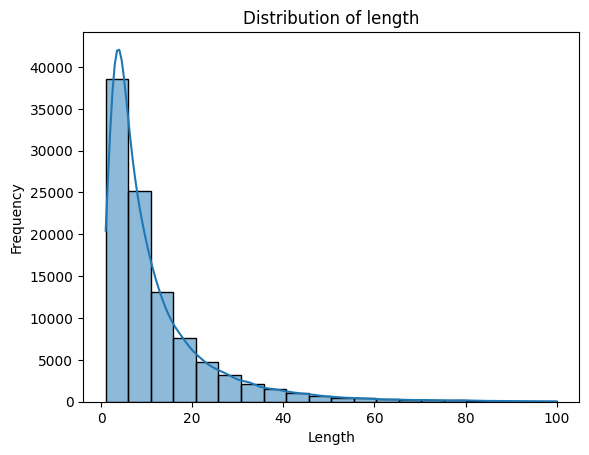

In [ ]:
# plot distribtion for length column
sns.histplot(merge_data['length'], bins=20, kde=True)
plt.title('Distribution of length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

As the characteristic of the data distribution is **right skewed**

In [ ]:
merge_data.shape

(100000, 2)

What about the distribtion of **rate** column?

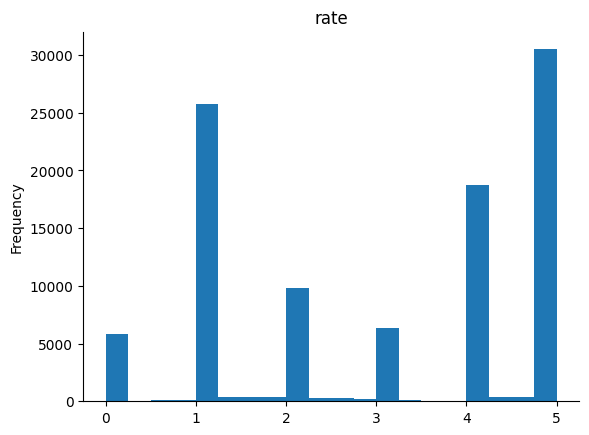

In [ ]:
merge_data['rate'].plot(kind='hist', bins=20, title='rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

Cool 👍

**Step 5**:
- <font color='blue'>**Label each text based on rete**</font>




Label <font color='green'>**positive**</font> if rate is more than equal **4**
else <font color='red'>**negative**</font>

In [ ]:
# create "label" column
# map rate to positive if more or equal than 4 else negative
merge_data['label'] = merge_data['rate'].apply(lambda x: 'positive' if x >= 4 else 'negative')

In [ ]:
merge_data.head()

,body,rate,length,label
3180198,راضی بودم,5.0,2,positive
111100,عالیه حتماً بخرید قیمت مناسب کیفیت عالی راحت و...,5.0,10,positive
996814,کیفیت خوب,4.0,2,positive
4229636,عالی برای مسلط شدن به نرم افزار,5.0,7,positive
2474193,خوب بود همون رنگ که میخواستم,5.0,6,positive


In [ ]:
# Drop rate
merge_data.drop(columns=['rate'],inplace=True)

In [ ]:
# Check how many positive label are there
merge_data['label'].value_counts()

,count
label,
positive,50000
negative,50000


Great⚡

Now it's time to classify our dataset

# **Pre-Process**

**Step 1**:
- <font color='blue'>**Do pre processing**</font>
- <font color='blue'>**Plot the most common words**</font>

First we **Normalize** texts

In [ ]:
# Let's normolize body column
normalizer = Normalizer()
merge_data['body'] = merge_data['body'].apply(lambda x: normalizer.normalize(x))
copy_merge_data['body'] = copy_merge_data['body'].apply(lambda x: normalizer.normalize(x))

In [ ]:
# Give example
text= "سلام    دنیا"
print(f'Text before being normalized: {text}')
print(f'Text after being normalized: {normalizer.normalize(text)}')

Text before being normalized: سلام    دنیا
Text after being normalized: سلام دنیا


Are there any **punctuation**?

- Remove them

In [ ]:
# Remove punctuation
merge_data['body'] = merge_data['body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
copy_merge_data['body'] = copy_merge_data['body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

It's time to toknize texts

In [ ]:
# Tokenize
tokenizer = WordTokenizer(replace_numbers=True, replace_ids=True)
merge_data['tokenizer'] = merge_data['body'].astype(str).apply(lambda x: tokenizer.tokenize(x))

In [ ]:
# Example
text = "سلام چطوری؟"
print(f'Text before being tokenized: {text}')
print(f'Text after being tokenized: {tokenizer.tokenize(text)}')

Text before being tokenized: سلام چطوری؟
Text after being tokenized: ['سلام', 'چطوری', '؟']


In [ ]:
# # Stemmer
# stemmer = Stemmer()
# merge_data['body'] = merge_data['body'].apply(lambda x: [stemmer.stem(word) for word in x])

In [ ]:
# Example
text = "کتاب‌هایی"
print(f'Text before being stemmed: {text}')
print(f'Text after being stemmed: {stemmer.stem(text)}')

Text before being stemmed: کتاب‌هایی
Text after being stemmed: کتاب


To find the roots of words and better understand them for the model, we perform a Lemmatizer.

In [ ]:
# Lemmetizer
lemmatizer = Lemmatizer()
merge_data['tokenizer'] = merge_data['tokenizer'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [ ]:
# Example
text = "می‌روم"
print(f'Text before being lemmatized: {text}')
print(f'Text after being lemmatized: {lemmatizer.lemmatize(text)}')

Text before being lemmatized: می‌روم
Text after being lemmatized: رفت#رو


See all **Stopwrods** in **Persian**

In [ ]:
# Print all stopwords in Persian
stopwords = stopwords_list()
print(stopwords)

['آخرین', 'آقای', 'آمد', 'آمده', 'آمده_است', 'آن', 'آنان', 'آنجا', 'آنها', 'آنچه', 'آنکه', 'آورد', 'آوری', 'آیا', 'ابتدا', 'اثر', 'اجرا', 'اخیر', 'از', 'است', 'اش', 'اغلب', 'افراد', 'افرادی', 'افزود', 'البته', 'اما', 'امر', 'امکان', 'اند', 'او', 'اول', 'اولین', 'اکنون', 'اگر', 'ایشان', 'این', 'اینجا', 'اینکه', 'با', 'بار', 'باره', 'باز', 'باشد', 'باشند', 'باعث', 'بالا', 'باید', 'بخش', 'بخشی', 'بدون', 'بر', 'برابر', 'براساس', 'برای', 'برخی', 'برداری', 'بروز', 'بزرگ', 'بسیار', 'بسیاری', 'بعد', 'بعضی', 'بلکه', 'بنابراین', 'بندی', 'به', 'بهتر', 'بهترین', 'بود', 'بودن', 'بودند', 'بوده', 'بوده_است', 'بی', 'بیان', 'بیرون', 'بیش', 'بیشتر', 'بیشتری', 'بین', 'تا', 'تاکنون', 'تبدیل', 'تحت', 'ترتیب', 'تعداد', 'تعیین', 'تغییر', 'تمام', 'تمامی', 'تنها', 'تهیه', 'تو', 'جا', 'جاری', 'جای', 'جایی', 'جدی', 'جدید', 'جریان', 'جز', 'جمع', 'جمعی', 'حال', 'حالا', 'حالی', 'حتی', 'حد', 'حداقل', 'حدود', 'حل', 'خاص', 'خاطرنشان', 'خصوص', 'خطر', 'خواهد_بود', 'خواهد_شد', 'خواهد_کرد', 'خوب', 'خوبی', 'خود', 'خودش', '

In [ ]:
# get frequency of stopwords in body column
stopwords_freq = {}
for text in merge_data['tokenizer']:
    for word in text:
        if word in stopwords:
            if word in stopwords_freq:
                stopwords_freq[word] += 1
            else:
                stopwords_freq[word] = 1

In [ ]:
# sort stopwrods_freq
stopwords_freq = sorted(stopwords_freq.items(), key=lambda x: x[1], reverse=True)
stopwords_freq[:10]

[('و', 41981),
 ('خوب', 19283),
 ('به', 17821),
 ('از', 15919),
 ('که', 13548),
 ('من', 12085),
 ('با', 10636),
 ('رو', 10486),
 ('این', 8977),
 ('در', 6115)]

> <font color='red'>**Note:**</font>
- We should remove some words from stopwrods because they are important words to analyze if a text is **positive** or **negative**

In [ ]:
# Remove عالی و خوب from stopwords
stopwords.remove('عالی')
stopwords.remove('خوب')


**Earlier we make a copy from our sample to chech the most common words**

Here we Check it:

In [ ]:
# Split body column
copy_merge_data['body'] = copy_merge_data['body'].apply(lambda x: x.split())

In [ ]:
# Remove stopwords in body
copy_merge_data['body'] = copy_merge_data['body'].apply(lambda x: [word for word in x if word not in stopwords])

In [ ]:
all_words = []
for text in copy_merge_data['body']:  # Iterate through each list in 'body'
    all_words.extend(text)  # Extend all_words with the words from the current list
all_words = ' '.join(all_words).split()  # Now join the flattened list
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

In [ ]:
most_common_words_list = list(zip(most_common_words['word'], most_common_words['frequency']))

# Fix x-axis in persian
most_common_words_persian = [(get_display(reshape(word)), freq) for word, freq in most_common_words_list]

# Update the DataFrame with the reshaped words
most_common_words['word'] = [word for word, _ in most_common_words_persian]

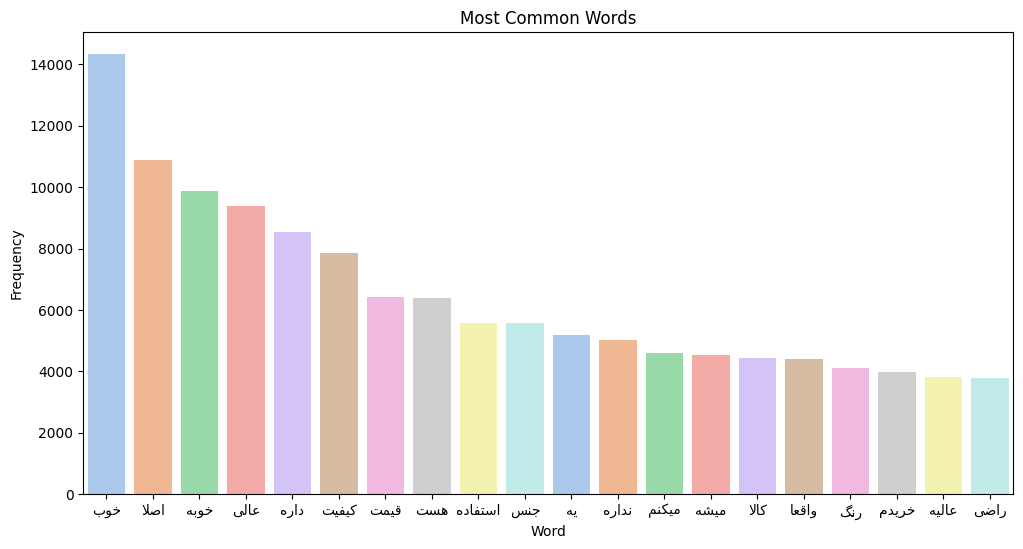

In [ ]:
# plot most common words
most_common_words = pd.DataFrame(most_common_words, columns=['word', 'frequency'])
plt.figure(figsize=(12, 6))
# Use color for each bar
colors = sns.color_palette('pastel', n_colors=len(most_common_words))
sns.barplot(x='word', y='frequency', data=most_common_words, palette=colors)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.show()

It seems good.

Some words that are important for our analysis have the most frequent

In [ ]:
# Stopwords
merge_data['tokenizer'] = merge_data['tokenizer'].apply(lambda x: [word for word in x if word not in stopwords])

There are some unusal symbol thus we remove

In [ ]:
# replce \u200c, \u2066◉,\u2060‿,\u2060◉,\u2069 to ''
merge_data['tokenizer'] = merge_data['tokenizer'].apply(lambda x: [word.replace('\u200c', '') for word in x])
merge_data['tokenizer'] = merge_data['tokenizer'].apply(lambda x: [word.replace('\u2066◉', '') for word in x])
merge_data['tokenizer'] = merge_data['tokenizer'].apply(lambda x: [word.replace('\u2060‿', '') for word in x])
merge_data['tokenizer'] = merge_data['tokenizer'].apply(lambda x: [word.replace('\u2060◉', '') for word in x])
merge_data['tokenizer'] = merge_data['tokenizer'].apply(lambda x: [word.replace('\u2069', '') for word in x])

In [ ]:
merge_data.head()

,body,length,label,tokenizer
3180198,راضی بودم,2,positive,"[راضی, بود#است]"
111100,عالیه حتما بخرید قیمت مناسب کیفیت عالی راحت و ...,10,positive,"[عالیه, حتما, خرید#خر, قیمت, کیفیت, عالی, راحت..."
996814,کیفیت خوب,2,positive,"[کیفیت, خوب]"
4229636,عالی برای مسلط شدن به نرمافزار,7,positive,"[عالی, مسلط, نرمافزار]"
2474193,خوب بود همون رنگ که میخواستم,6,positive,"[خوب, بود#است, همون, رنگ, میخواستم]"


Before split data let's check how many rows in body are empty:

In [ ]:
empty_rows = merge_data[merge_data['tokenizer'].apply(lambda x: len(x)) == 0]
empty_rows.shape[0]

110

In [ ]:
# Remove empty rows
merge_data.drop(empty_rows.index,inplace=True)

There are also some <font color='purple'>**emojies**</font> in dataset.
They are should be removed

In [ ]:
# Remove emojis
def remove_emojis(text):
    # Check if the input is a string or bytes-like object
    if isinstance(text, (str, bytes)):
        emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FAFF\U00002700-\U000027BF]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    # If not, try converting it to a string or return the original input
    # This handles cases where the input might be a list or another type
    else:
        try:
            return remove_emojis(str(text))
        except TypeError:
            return text

# Apply the function to each element of the Series using .apply()
tokenized = tokenized.apply(remove_emojis)

In [ ]:
# import re

# # Remove emojis
# def remove_emojis(text):
#     emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FAFF\U00002700-\U000027BF]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', text)
# # Apply the function to each element of the Series using .apply()
# tokenized = tokenized.apply(remove_emojis)

# **Train Machine Learing Algorithms**

Identify target and other column

In [ ]:
tokenized = merge_data['tokenizer']
label = merge_data['label']

In [ ]:
tokenized = tokenized.apply(lambda x: ' '.join(x))

In [ ]:
# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(tokenized, label, test_size=0.2, random_state=42)

The vectorizer will ignore words that appear in fewer than **1%** of the documents and those that appear in more than **98%** of the documents.

This helps filter out rare and overly common words, focusing on more relevant terms.

In [ ]:
# Create conter vectorize and set vocab size
count_vectorizer = CountVectorizer(min_df=0.01,max_df=0.98)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)


**How many models will be used?**

- **We analyze 4 models on our sample dataset**
  - <font color='blue'>**Logistic Regression**</font>
  - <font color='blue'>**Naive Bayse**</font>
  - <font color='blue'>**XGBoost**</font>
  - <font color='blue'>**KNN**</font>

Let's go to do that:

In [ ]:
# Train logistic regression
lr = LogisticRegression()
lr.fit(X_train_count, y_train)

# Predict
y_pred = lr.predict(X_test_count)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.80      0.87      0.83      9925
    positive       0.86      0.79      0.82     10052

    accuracy                           0.83     19977
   macro avg       0.83      0.83      0.83     19977
weighted avg       0.83      0.83      0.83     19977



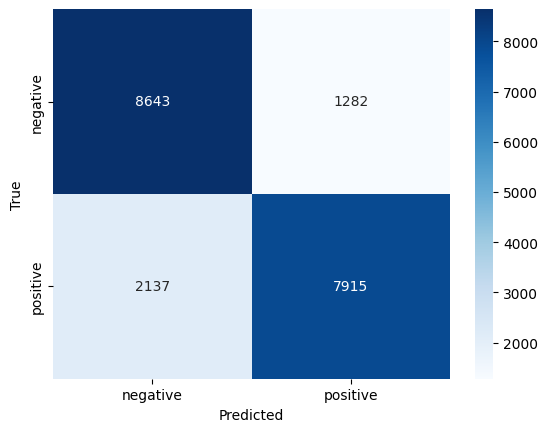

In [ ]:
# plot confusion matrix with positive and negative labels
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Using naive bayes
nb = MultinomialNB()
nb.fit(X_train_count, y_train)

# Predict
y_pred = nb.predict(X_test_count)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.81      0.84      0.82      9925
    positive       0.84      0.80      0.82     10052

    accuracy                           0.82     19977
   macro avg       0.82      0.82      0.82     19977
weighted avg       0.82      0.82      0.82     19977



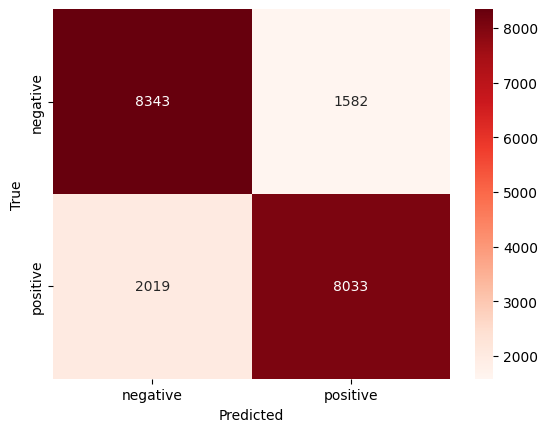

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = le.fit_transform(y_train)

# Initialize XGBClassifier
xgb = XGBClassifier()

# Fit the model using the encoded target variable
xgb.fit(X_train_count, y_train_encoded)

# Predict
y_pred = xgb.predict(X_test_count)

# Inverse transform the predictions to get original labels
y_pred = le.inverse_transform(y_pred)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.80      0.88      0.84      9925
    positive       0.87      0.79      0.83     10052

    accuracy                           0.83     19977
   macro avg       0.84      0.83      0.83     19977
weighted avg       0.84      0.83      0.83     19977



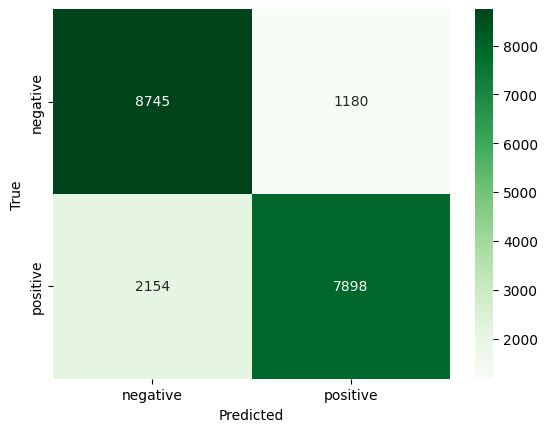

In [ ]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Using knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_count, y_train)

# Predict
y_pred = knn.predict(X_test_count)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.82      0.76      0.79      9925
    positive       0.78      0.84      0.81     10052

    accuracy                           0.80     19977
   macro avg       0.80      0.80      0.80     19977
weighted avg       0.80      0.80      0.80     19977



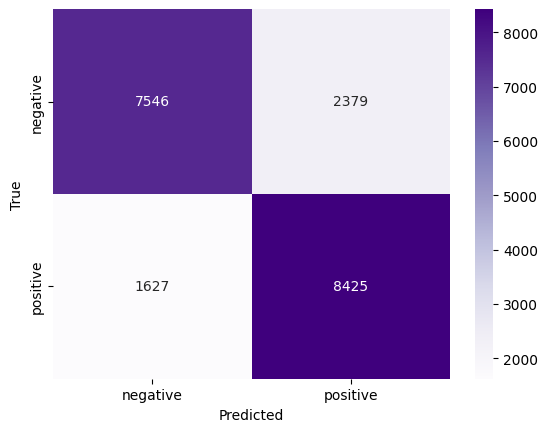

In [ ]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Two models have more **accuracy** than others:
- **Logistic regression**
- **XGBoost**

# **Word2vec**

Tokenizing each document into a list of lowercase words

In [ ]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
X_train_tokens = [simple_preprocess(doc) for doc in X_train]
X_test_tokens = [simple_preprocess(doc) for doc in X_test]

Initializes a Word2Vec model with a vector size of 100, a context window of 5, and uses 4 worker threads, training on tokenized sentences from

In [ ]:
# Implement wrod2vec
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Define a function to get avgrage word2vec
def get_average_word2vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

Containing the average Word2Vec vectors for each document

In [ ]:
X_train_w2v = np.array([get_average_word2vec(doc, w2v_model, 100) for doc in X_train_tokens])
X_test_w2v = np.array([get_average_word2vec(doc, w2v_model, 100) for doc in X_test_tokens])

Do the same way from **machine learning** part

In [ ]:
# Using logisitc regression
lr = LogisticRegression()
lr.fit(X_train_w2v, y_train)

# Predict
y_pred = lr.predict(X_test_w2v)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      9925
    positive       0.88      0.86      0.87     10052

    accuracy                           0.87     19977
   macro avg       0.87      0.87      0.87     19977
weighted avg       0.87      0.87      0.87     19977



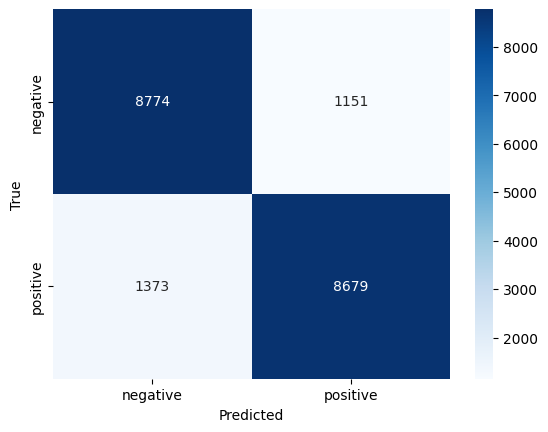

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data to the range [0, 1]
scaler = MinMaxScaler()
X_train_w2v_scaled = scaler.fit_transform(X_train_w2v)
X_test_w2v_scaled = scaler.transform(X_test_w2v)

# Using naive bayes
nb = MultinomialNB()
nb.fit(X_train_w2v_scaled, y_train) # Use scaled data here

# Predict
y_pred = nb.predict(X_test_w2v_scaled) # Use scaled data here

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.76      0.91      0.83      9925
    positive       0.89      0.71      0.79     10052

    accuracy                           0.81     19977
   macro avg       0.83      0.81      0.81     19977
weighted avg       0.83      0.81      0.81     19977



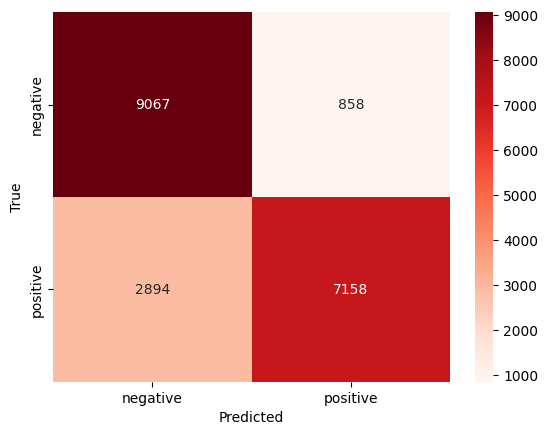

In [ ]:
# Plot confustion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Using XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

xgb = XGBClassifier()
xgb.fit(X_train_w2v, y_train_encoded)

# Predict
y_pred_encoded = xgb.predict(X_test_w2v) # Get encoded predictions

# Decode predictions back to original labels
y_pred = le.inverse_transform(y_pred_encoded)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.88      9925
    positive       0.88      0.87      0.88     10052

    accuracy                           0.88     19977
   macro avg       0.88      0.88      0.88     19977
weighted avg       0.88      0.88      0.88     19977



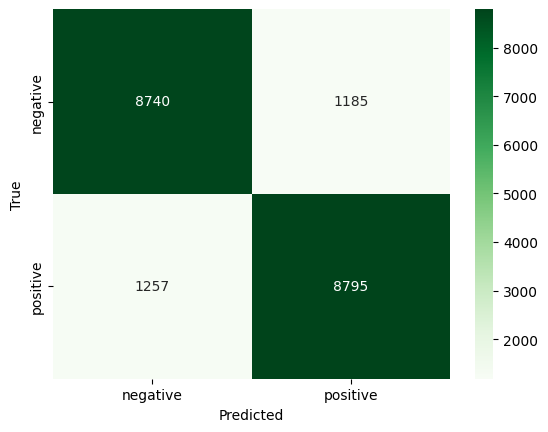

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Using knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_w2v, y_train)

# Predict
y_pred = knn.predict(X_test_w2v)

# Evaluate
print(classification_report(y_test, y_pred))

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c748c3444c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so: cannot open shared object file: No such file or directory


              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      9925
    positive       0.87      0.83      0.85     10052

    accuracy                           0.85     19977
   macro avg       0.85      0.85      0.85     19977
weighted avg       0.85      0.85      0.85     19977



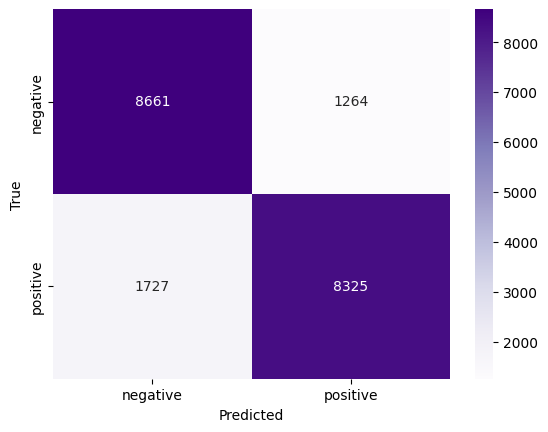

In [ ]:
# Plot confustion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

This time, <font color='darkgreen'>**XGBoost**</font> has the highest **accuracy**.

# **LSTM**

Using **FastText** to get **embeddings**

In [ ]:
fast_model = fasttext.load_model(hf_hub_download("facebook/fasttext-fa-vectors", "model.bin"))

model.bin:   0%|          | 0.00/7.25G [00:00<?, ?B/s]

count word occurrences in tokenized texts

In [ ]:
counter = Counter(word for text in merge_data['tokenizer'] for word in text)
limited = counter.most_common(10000)

Create a vocabulary dictionary from tokenized texts, mapping words to unique integers while filtering by frequency and limiting the size to a specified maximum.

It adds special tokens for padding and unknown words, returning the resulting dictionary.

In [ ]:
# build vocab dictinary
def build_vocab(tokenized_texts, max_vocab_size=10000, min_freq=1):
    """
    Build a vocabulary mapping with a maximum size.
    :param tokenized_texts: List of tokenized texts
    :param max_vocab_size: Maximum vocabulary size (including special tokens)
    :param min_freq: Minimum frequency for words to be included
    :return: A dictionary mapping words to unique integers
    """
    # Calculate word frequencies
    word_freq = Counter(word for text in tokenized_texts for word in text)

    # Filter by min_freq and sort by frequency (descending) and alphabetically (ascending)
    sorted_vocab = sorted(
        [(word, freq) for word, freq in word_freq.items() if freq >= min_freq],
        key=lambda x: (-x[1], x[0])  # Sort by frequency (desc), then alphabetically
    )

    # Limit the vocabulary size
    limited_vocab = sorted_vocab[: max_vocab_size - 2]  # Reserve space for <PAD> and <UNK>

    # Add special tokens
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, _ in limited_vocab:
        vocab[word] = len(vocab)

    return vocab

vocab = build_vocab(merge_data['tokenizer'])
print(f'Vocab size: {len(vocab)}')

Vocab size: 10000


Convert tokenized texts into sequences of integers based on a provided vocabulary, replacing unknown words with the <font color='red'>**Unknown**</font> token.

In [ ]:
# Text to sequence

def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab['<UNK>']) for word in text]
        sequences.append(sequence)
    return sequences

merge_data['sequence'] =  text_to_sequence(merge_data['tokenizer'], vocab)
merge_data.head()

,body,label,tokenizer,sequence
3203087,بار چندمی هست که خرید میکنم \nپوست رو نرم میکن...,positive,"[چندم, هست, خرید, میکنم, پوست, نرم, میکنه, بوی...","[2643, 15, 26, 22, 58, 104, 40, 41, 12, 402, 5..."
1589334,عالی بود,positive,"[عالی, بود#است]","[9, 2]"
5222279,امروز بدستم رسید برای زمستان خوبه ولی برچسبش و...,positive,"[امروز, بدستید#بدست, زمستان, خوبه, برچسب, کرد#...","[530, 406, 2988, 8, 291, 4, 766, 293]"
4048314,شامپو خوبیه,positive,"[شامپو, خوبیه]","[163, 67]"
493564,خیلی عالیه,positive,[عالیه],[34]


It's time to create **Dataset** we want

In [ ]:

# Create Sentiment dataset
class SentimentDataset(Dataset):
  def __init__(self, data, vocab, label_col='labels', tokens_col='tokenizer', max_len=128):
    self.data = data
    self.vocab = vocab
    self.label_col = label_col
    self.tokens_col = tokens_col
    self.max_len = max_len
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data.iloc[idx][self.tokens_col]
    label = self.data.iloc[idx][self.label_col]

    # Convert text to sequence
    indices = [self.vocab.get(word, self.vocab['<UNK>']) for word in text]

    return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Use padding function
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padding_sequences = pad_sequence(
        [torch.tensor(seq, dtype=torch.long) for seq in sequences],
        batch_first=True,
        padding_value=vocab['<PAD>']
    )
    return padding_sequences, torch.stack(labels)



Implement **BiLSTM**

In [ ]:
# Create BiLSTM classifier

class BiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix=None):
    super(BiLSTM, self).__init__()
    # embedding layer with the specified vocab size and embedding dimension
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    if embedding_matrix is not None:
       self.embedding.weight = nn.Parameter(embedding_matrix)
       self.embedding.weight.requires_grad = False

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
    # fully connected layer that transforms the concatenated hidden states of both LSTM directions
    self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
    self.fc2 = nn.Linear(hidden_dim * 2, output_dim)


  def forward(self, x):
    embedded = self.embedding(x)
    # Get the outputs and hidden states from the LSTM
    _, (hidden, cell) = self.lstm(embedded)
    hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
    hidden = self.fc1(hidden)
    output = self.fc2(hidden)
    return output



Create an embedding matrix from a vocabulary of words

In [ ]:
EMBEDDING_SIZE = 300
embedding_matrix = np.zeros((len(vocab), EMBEDDING_SIZE))
for word, index in vocab.items():
    if word in fast_model:
        embedding_matrix[index] = fast_model.get_word_vector(word)

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

Initializes a Bidirectional LSTM

In [ ]:
model = BiLSTM(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=128,
    output_dim=2,
    embedding_matrix=embedding_matrix
)


# Difine Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



To prevent error, we need to encode label positive and negative to integer

In [ ]:
# Encode labels
le = LabelEncoder()
merge_data['label_encoded'] = le.fit_transform(merge_data['label'])

In [ ]:
# Splitting the dataset into train, validation, and test sets
train_data, temp_data = train_test_split(merge_data, test_size=0.3, random_state=42)  # 70% train, 30% temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 15% val, 15% test

In [ ]:
# Batch size
batch_size = 64

train_dataset = SentimentDataset(train_data, vocab, label_col='label_encoded', tokens_col='tokenizer')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Instance for validation and test data with sentimentdataset and dataloader
val_dataset = SentimentDataset(val_data, vocab, label_col='label_encoded', tokens_col='tokenizer')
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_dataset = SentimentDataset(test_data, vocab, label_col='label_encoded', tokens_col='tokenizer')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

We train the model.

In each epoch if we get better **loss** for validation set, we choose that model as a best

In [ ]:
# Training loop with validation
best_val_loss = float('inf')  # Track the best validation loss
num_epochs = 10
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_dataloader):  # Train DataLoader
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

    # --- Validation Phase ---
    model.eval()
    val_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:  # Validation DataLoader
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Average validation loss
    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

    # Compute validation metrics (e.g., accuracy)
    val_accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}')

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved!")



100%|██████████| 1093/1093 [05:53<00:00,  3.09it/s]


Epoch [1/10], Training Loss: 0.2787
Epoch [1/10], Validation Loss: 0.2731
Epoch [1/10], Validation Accuracy: 0.8873
Best model saved!


100%|██████████| 1093/1093 [06:05<00:00,  2.99it/s]


Epoch [2/10], Training Loss: 0.2599
Epoch [2/10], Validation Loss: 0.2621
Epoch [2/10], Validation Accuracy: 0.8919
Best model saved!


100%|██████████| 1093/1093 [05:59<00:00,  3.04it/s]


Epoch [3/10], Training Loss: 0.2451
Epoch [3/10], Validation Loss: 0.2579
Epoch [3/10], Validation Accuracy: 0.8923
Best model saved!


100%|██████████| 1093/1093 [05:47<00:00,  3.15it/s]


Epoch [4/10], Training Loss: 0.2344
Epoch [4/10], Validation Loss: 0.2525
Epoch [4/10], Validation Accuracy: 0.8963
Best model saved!


100%|██████████| 1093/1093 [05:33<00:00,  3.28it/s]


Epoch [5/10], Training Loss: 0.2258
Epoch [5/10], Validation Loss: 0.2538
Epoch [5/10], Validation Accuracy: 0.8970


100%|██████████| 1093/1093 [05:33<00:00,  3.27it/s]


Epoch [6/10], Training Loss: 0.2163
Epoch [6/10], Validation Loss: 0.2509
Epoch [6/10], Validation Accuracy: 0.8965
Best model saved!


100%|██████████| 1093/1093 [06:22<00:00,  2.85it/s]


Epoch [7/10], Training Loss: 0.2086
Epoch [7/10], Validation Loss: 0.2572
Epoch [7/10], Validation Accuracy: 0.9010


100%|██████████| 1093/1093 [05:38<00:00,  3.23it/s]


Epoch [8/10], Training Loss: 0.1986
Epoch [8/10], Validation Loss: 0.2480
Epoch [8/10], Validation Accuracy: 0.8979
Best model saved!


100%|██████████| 1093/1093 [05:46<00:00,  3.15it/s]


Epoch [9/10], Training Loss: 0.1891
Epoch [9/10], Validation Loss: 0.2569
Epoch [9/10], Validation Accuracy: 0.8977


100%|██████████| 1093/1093 [05:46<00:00,  3.15it/s]


Epoch [10/10], Training Loss: 0.1785
Epoch [10/10], Validation Loss: 0.2749
Epoch [10/10], Validation Accuracy: 0.8965


In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [ ]:
# Evaluate on test data
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

# Compute final test metrics
print("Test Accuracy:", accuracy_score(all_labels, all_predictions))

Test Accuracy: 0.8992258408969568


In [ ]:
print("Classification Report:\n", classification_report(all_labels, all_predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      7452
           1       0.89      0.91      0.90      7532

    accuracy                           0.90     14984
   macro avg       0.90      0.90      0.90     14984
weighted avg       0.90      0.90      0.90     14984



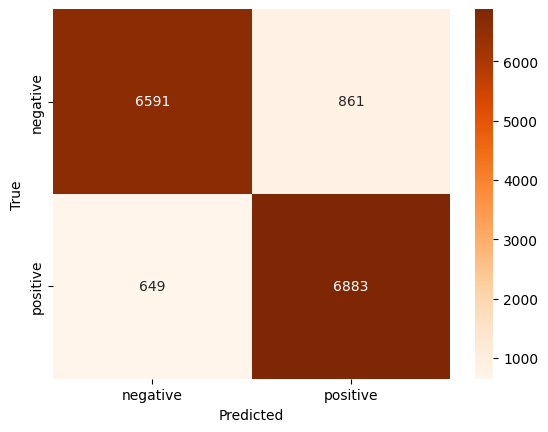

In [ ]:
# plot confustion matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Great!!

The accuracy is almost **90%**

We want to get some outputs that BiLSTM was predicted

In [ ]:
# Convert predictions back to original label format
all_predicted_labels = le.inverse_transform(all_predictions)
all_true_labels = all_labels  # Assign the true labels from the test data
all_true_labels = le.inverse_transform(all_true_labels)

In [ ]:
# Create a DataFrame to view instances, true labels, and predictions
results_df = pd.DataFrame({'Text': test_data['body'],
                            'True Label': all_true_labels,
                            'Predicted Label': all_predicted_labels})
# View specific examples based on conditions (e.g., incorrect predictions)
incorrect_predictions = results_df[results_df['True Label'] != results_df['Predicted Label']]

In [ ]:
# Print 5 random examples separately
for i in range(5):
    example = results_df.sample(1)  # Get one random sample
    print(f"Example {i+1}:")
    print("Text:", example['Text'].values[0])
    print("True Label:", example['True Label'].values[0])
    print("Predicted Label:", example['Predicted Label'].values[0])
    print("-" * 20)  # Separator between examples

Example 1:
Text: دوسش داشتم 
بوی خوب و خاصی داره 
True Label: positive
Predicted Label: positive
--------------------
Example 2:
Text: من تیشرت ۳ ایکس لارج سفارش دادم اسمال رسید دستم هم ضایع شدم هم دعوام کردن
True Label: negative
Predicted Label: negative
--------------------
Example 3:
Text: به شدت باعث خشکسه پوستم شد هرچی قبلش اب رسان استفاده کردم به هدر رفت
پیش از این مدل رزشو استفاده میکردم اون خیلی بهتر بود این یکی پوستمو داغون کرد
True Label: negative
Predicted Label: negative
--------------------
Example 4:
Text: تا حدودی خوب بود
True Label: negative
Predicted Label: positive
--------------------
Example 5:
Text: بنظرم خوب بود
True Label: positive
Predicted Label: positive
--------------------


# **ParsBERT**

How about **Large Language Models**?

We use **ParsBERT** because It's better on **Persian** task.

Let's do it:

In [ ]:
# implement parsbert

MODEL_PATH = 'HooshvareLab/bert-fa-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
config = BertConfig.from_pretrained(MODEL_PATH)
model = BertModel.from_pretrained(MODEL_PATH, config=config)



> <font color='red'>**Note:**</font>
- **We ran different max_lengths and more samples for different text lengths, but unfortunately, since we didn't have access to the GPU and running it on the CPU crashed, we had to take smaller samples 😞**

Get text that have length smaller equal than 16

In [ ]:
# Filter data that x.split() is less than 16 for body
filter_data = merge_data[merge_data['body'].apply(lambda x: len(x.split()) <= 16)]
filter_data.head()

,body,length,label,tokenizer,label_encoded
3180198,راضی بودم,2,positive,"[راضی, بود#است]",1
111100,عالیه حتما بخرید قیمت مناسب کیفیت عالی راحت و ...,10,positive,"[عالیه, حتما, خرید#خر, قیمت, کیفیت, عالی, راحت...",1
996814,کیفیت خوب,2,positive,"[کیفیت, خوب]",1
4229636,عالی برای مسلط شدن به نرمافزار,7,positive,"[عالی, مسلط, نرمافزار]",1
2474193,خوب بود همون رنگ که میخواستم,6,positive,"[خوب, بود#است, همون, رنگ, میخواستم]",1


First get 1000 sample for each positive and negative

In [ ]:
# get 5000 sample data from positive and negative label
positive_data = filter_data[filter_data['label'] == 'positive'].sample(1000)
negative_data = filter_data[filter_data['label'] == 'negative'].sample(1000)

# merge them
sample_data = pd.concat([positive_data, negative_data])

In [ ]:
sample_data['label'].value_counts()

,count
label,
positive,1000
negative,1000


In [ ]:
# Drop length column
sample_data.drop(columns=['length'], inplace=True)

In [ ]:
# Get the max lentgh from sample size
max_length = sample_data['body'].apply(lambda x: len(x.split())).max()
print(f'Max length: {max_length}')

Max length: 16


In [ ]:
# Splitting the dataset into train, validation, and test sets
train_data, temp_data = train_test_split(sample_data, test_size=0.3, random_state=42)  # 70% train, 30% temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 15% val, 15% test

Check for one text to see the model runs well

In [ ]:
idx = np.random.randint(0, len(train_data))
text = train_data.iloc[idx]['body']
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Text: {text}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Text: بسیار نازک
Tokens: ['بسیار', 'نازک']
Token IDs: [3177, 10866]


- Encodes a given text using a tokenizer
- Preparing it for input into a model by adding special tokens
- Truncating or padding to a maximum length of 16
- Generating attention and token type masks

In [ ]:
# Encoding

encoding = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=16,
    return_token_type_ids=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

for key, value in encoding.items():
    print(f'{key}: {value.numpy().tolist()}')


input_ids: [[2, 3177, 10866, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
token_type_ids: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
attention_mask: [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


**input_ids:**
- Contains the token IDs representing the encoded input text.

**token_type_ids:**
- Indicates segment membership of tokens, useful for distinguishing between multiple sentences (0 for the first sentence, 1 for the second).

**attention_mask:**
- Specifies which tokens should be attended to by the model (1 for real tokens, 0 for padding).


Create **Dataset**

In [ ]:
# Digikala comments dataset
class SentimentDigiKala(Dataset):
  def __init__(self, data, tokenizer, max_length=16, label_col='label_encoded', text_col='body'):
    self.data = data
    self.label_col = label_col
    self.text_col = text_col
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data.iloc[idx][self.text_col]
    label = self.data.iloc[idx][self.label_col]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )

    inputs = {
        'comment': text,
        'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
        'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
        'token_type_ids': torch.tensor(encoding['token_type_ids'], dtype=torch.long),
        }

    inputs['label'] = torch.tensor(label, dtype=torch.long)

    return label, inputs


In [ ]:
train_dataset = SentimentDigiKala(train_data, tokenizer, label_col='label_encoded', text_col='body')
val_dataset = SentimentDigiKala(val_data, tokenizer, label_col='label_encoded', text_col='body')
test_dataset = SentimentDigiKala(test_data, tokenizer, label_col='label_encoded', text_col='body')

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,pin_memory=True)
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,pin_memory=True)

In [ ]:
class SentimentModel(nn.Module):
  def __init__(self, model_name, config):
    super(SentimentModel, self).__init__()
    self.bert = BertModel.from_pretrained(model_name, config=config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, input_ids, attention_mask, token_type_ids):
    # Get the hidden states from the BERT model
    # Assuming your BERT model outputs a tuple/dictionary where the first element
    # or the key 'last_hidden_state' contains the hidden states.
    # Adapt this based on your specific BERT model output structure
    outputs = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
        token_type_ids = token_type_ids
    ).last_hidden_state  # Access the 'last_hidden_state'
    # OR
    # outputs = self.bert(
    #     input_ids = input_ids,
    #     attention_mask = attention_mask,
    #     token_type_ids = token_type_ids
    # )[0]  # Access the first element (if it's a tuple)


    # Apply dropout to the pooled output (the [CLS] token representation)
    pooled_output = outputs[:, 0]  # Extract the [CLS] token representation
    pooled_output = self.dropout(pooled_output)

    # Pass the pooled output through the classifier
    logits = self.classifier(pooled_output)
    return logits

In [ ]:
config.num_labels = 2

pt_model = SentimentModel(MODEL_PATH, config)
print(f'pt_model : {type(pt_model)}')

pt_model : <class '__main__.SentimentModel'>


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(pt_model.parameters(), lr=2e-5)

In [ ]:
# Define early stopping parameters
early_stop_patience = 2  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize best validation loss
no_improvement_epochs = 0  # Count epochs without improvement

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pt_model = pt_model.to(device)

for epoch in range(num_epochs):
    pt_model.train()
    total_loss = 0

    for batch in tqdm(train_data_loader):
        # Assuming the batch is a list containing two elements:
        labels = batch[0].to(device)  # Labels
        input_ids = batch[1]['input_ids'].to(device)
        attention_mask = batch[1]['attention_mask'].to(device)
        token_type_ids = batch[1]['token_type_ids'].to(device)

        outputs = pt_model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_data_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # Validate the model
    pt_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_data_loader:
            input_ids = batch[1]['input_ids'].to(device)
            attention_mask = batch[1]['attention_mask'].to(device)
            token_type_ids = batch[1]['token_type_ids'].to(device)
            labels = batch[0].to(device)

            outputs = pt_model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_data_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0  # Reset counter
        print(f"Validation loss improved to {val_loss:.4f}, saving model.")
        torch.save(pt_model.state_dict(), "best_model.pth")  # Save the best model
    else:
        no_improvement_epochs += 1
        print(f"No improvement in validation loss for {no_improvement_epochs} epoch(s).")

        if no_improvement_epochs >= early_stop_patience:
            print("Early stopping triggered. Stopping training.")
            break


100%|██████████| 22/22 [05:05<00:00, 13.88s/it]


Epoch 1/10, Training Loss: 0.0108
Validation Loss: 0.4139, Accuracy: 0.9133
Validation loss improved to 0.4139, saving model.


100%|██████████| 22/22 [04:54<00:00, 13.37s/it]


Epoch 2/10, Training Loss: 0.0069
Validation Loss: 0.3986, Accuracy: 0.9133
Validation loss improved to 0.3986, saving model.


100%|██████████| 22/22 [04:51<00:00, 13.25s/it]


Epoch 3/10, Training Loss: 0.0064
Validation Loss: 0.4132, Accuracy: 0.9167
No improvement in validation loss for 1 epoch(s).


100%|██████████| 22/22 [04:50<00:00, 13.22s/it]


Epoch 4/10, Training Loss: 0.0045
Validation Loss: 0.3908, Accuracy: 0.9233
Validation loss improved to 0.3908, saving model.


100%|██████████| 22/22 [04:51<00:00, 13.23s/it]


Epoch 5/10, Training Loss: 0.0050
Validation Loss: 0.4787, Accuracy: 0.9200
No improvement in validation loss for 1 epoch(s).


100%|██████████| 22/22 [04:57<00:00, 13.51s/it]


Epoch 6/10, Training Loss: 0.0101
Validation Loss: 0.3921, Accuracy: 0.9167
No improvement in validation loss for 2 epoch(s).
Early stopping triggered. Stopping training.


In [ ]:
# Evaluate model
pt_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_data_loader:
        # Assuming batch is a list, access elements using index
        input_ids = batch[1]['input_ids'].to(device)  # Assuming input_ids is at index 1
        attention_mask = batch[1]['attention_mask'].to(device)  # Assuming attention_mask is at index 1
        token_type_ids = batch[1]['token_type_ids'].to(device)  # Assuming token_type_ids is at index 1
        labels = batch[0].to(device) # Assuming labels is at index 0

        outputs = pt_model(input_ids, attention_mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Compute test accuracy and generate a classification report
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(all_labels, all_predictions))

Test Accuracy: 0.9200
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       151
           1       0.95      0.89      0.92       149

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

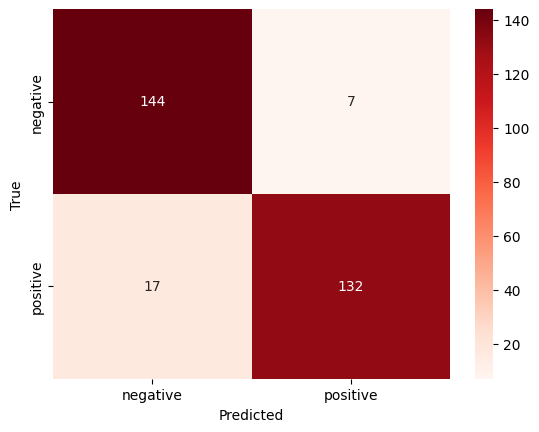

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt

The accuracy is about **92%**

We also tried to avoid overfitting.

#### **Let's do for 5000 samples**

In [ ]:
# Do for 5000 sample data
positive_data_1 = filter_data[filter_data['label'] == 'positive'].sample(2500)
negative_data_1 = filter_data[filter_data['label'] == 'negative'].sample(2500)

In [ ]:
sample_data_1 = pd.concat([positive_data_1, negative_data_1])

In [ ]:
# Drop length column
sample_data_1.drop(columns=['length'], inplace=True)

In [ ]:
# Get the max lentgh from sample size
max_length_1 = sample_data_1['body'].apply(lambda x: len(x.split())).max()
print(f'Max length: {max_length_1}')

Max length: 16


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train, validation, and test sets
train_data, temp_data = train_test_split(sample_data_1, test_size=0.3, random_state=42)  # 70% train, 30% temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 15% val, 15% test

In [ ]:
train_dataset = SentimentDigiKala(train_data, tokenizer, label_col='label_encoded', text_col='body')
val_dataset = SentimentDigiKala(val_data, tokenizer, label_col='label_encoded', text_col='body')
test_dataset = SentimentDigiKala(test_data, tokenizer, label_col='label_encoded', text_col='body')

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,pin_memory=True)
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,pin_memory=True)

In [ ]:
# Define early stopping parameters
early_stop_patience = 2  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize best validation loss
no_improvement_epochs = 0  # Count epochs without improvement

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pt_model = pt_model.to(device)

for epoch in range(num_epochs):
    pt_model.train()
    total_loss = 0

    for batch in tqdm(train_data_loader):
        # Assuming the batch is a list containing two elements:
        labels = batch[0].to(device)  # Labels
        input_ids = batch[1]['input_ids'].to(device)
        attention_mask = batch[1]['attention_mask'].to(device)
        token_type_ids = batch[1]['token_type_ids'].to(device)

        outputs = pt_model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_data_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # Validate the model
    pt_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_data_loader:
            input_ids = batch[1]['input_ids'].to(device)
            attention_mask = batch[1]['attention_mask'].to(device)
            token_type_ids = batch[1]['token_type_ids'].to(device)
            labels = batch[0].to(device)

            outputs = pt_model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_data_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0  # Reset counter
        print(f"Validation loss improved to {val_loss:.4f}, saving model.")
        torch.save(pt_model.state_dict(), "best_model.pth")  # Save the best model
    else:
        no_improvement_epochs += 1
        print(f"No improvement in validation loss for {no_improvement_epochs} epoch(s).")

        if no_improvement_epochs >= early_stop_patience:
            print("Early stopping triggered. Stopping training.")
            break


100%|██████████| 55/55 [12:34<00:00, 13.73s/it]


Epoch 1/10, Training Loss: 0.3062
Validation Loss: 0.1687, Accuracy: 0.9360
Validation loss improved to 0.1687, saving model.


100%|██████████| 55/55 [12:15<00:00, 13.37s/it]


Epoch 2/10, Training Loss: 0.1292
Validation Loss: 0.1809, Accuracy: 0.9387
No improvement in validation loss for 1 epoch(s).


100%|██████████| 55/55 [12:20<00:00, 13.46s/it]


Epoch 3/10, Training Loss: 0.0732
Validation Loss: 0.1985, Accuracy: 0.9413
No improvement in validation loss for 2 epoch(s).
Early stopping triggered. Stopping training.


In [ ]:
# Evaluate model
pt_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_data_loader:
        # Assuming batch is a list, access elements using index
        input_ids = batch[1]['input_ids'].to(device)  # Assuming input_ids is at index 1
        attention_mask = batch[1]['attention_mask'].to(device)  # Assuming attention_mask is at index 1
        token_type_ids = batch[1]['token_type_ids'].to(device)  # Assuming token_type_ids is at index 1
        labels = batch[0].to(device) # Assuming labels is at index 0

        outputs = pt_model(input_ids, attention_mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Compute test accuracy and generate a classification report
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}\n")
print(classification_report(all_labels, all_predictions))

Test Accuracy: 0.9293

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       360
           1       0.92      0.94      0.93       390

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

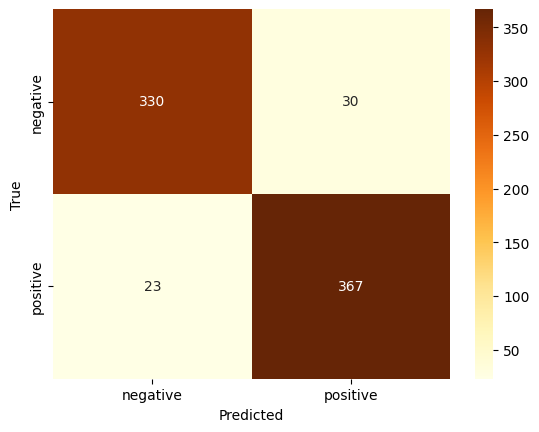

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt

For larger sample size, In this case 5000, An **accuracy** of <font color='blue'>**93%**</font> was obtained, which is the best value obtained.